# Import supporting package

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import copy

import glob

import xrft
import finufft

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

from datetime import datetime

import matplotlib.pyplot as plt


plt.rcParams['font.size'] = 18

from scipy.ndimage import gaussian_filter
import matplotlib as mpl
from scipy.optimize import curve_fit
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

import time

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()



In [20]:
# get center of thresholded image

def calc_cen(thresh1):
    """
    returns array: [Y_center,X_center]
    """
    cen = np.zeros(2)
    (Y,X) = np.shape(thresh1)


    thresh1 = thresh1 /np.sum(thresh1)

    # marginal distributions
    dx = np.sum(thresh1, 0)
    dy = np.sum(thresh1, 1)

    # expected values
    cen[0] = np.sum(dx * np.arange(X))
    cen[1] = np.sum(dy * np.arange(Y))
    return cen

def calc_cen_bulk(thresh):
    """
    returns array in shape of input, containing array with [Y_center,X_center] for each image
    """
    shape = np.shape(thresh)
    cen = np.zeros((shape[0], shape[1], 2))
    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            cen[i,j] = calc_cen(thresh[i,j])
    return cen

def guess_BEC_width(thresh, center):
    """
    returns width of thresholded area along both axis through the center with shape of thresh and [X_width, Y_width] for each image
    """
    shape = np.shape(thresh)
    BEC_width_guess = np.zeros((shape[0], shape[1], 2))

    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            BEC_width_guess[i, j, 0] = np.sum(thresh[i, j, round(center[i,j,1]), :])
            BEC_width_guess[i, j, 1] = np.sum(thresh[i, j, :, round(center[i,j,0])])

    return BEC_width_guess



def gaussian(x, x0, sigma, A):
    return A * np.exp(-0.5 * (x-x0)**2 / sigma**2)

def polylog(power, numerator, order = 15):

    dataShape = numerator.shape
    numerator = np.tile(numerator, (order, 1))
    numerator = np.power(numerator.T, np.arange(1, order+1)).T

    denominator = np.arange(1, order+1)
    denominator = np.tile(denominator, (dataShape[0], 1))
    denominator = denominator.T

    data = numerator/ np.power(denominator, power)

    return np.sum(data, axis=0)

def thermal(x, x0, amp, sigma, order = 15):
    res = np.exp(-0.5 * (x-x0)**2 / sigma**2)
    return amp * polylog(2, res, order)

def Thomas_Fermi_1d(x, x0, amp, sigma):
    res = (1-(( x - x0 ) / sigma) **2) **3/2
    return amp * np.where(res > 0, res, 0)

def density_1d(x, x0_bec, x0_th, amp_bec, amp_th, sigma_bec, sigma_th, polyorder=15):
    return thermal(x, x0_th, amp_th, sigma_th, polyorder) + Thomas_Fermi_1d(x, x0_bec, amp_bec, sigma_bec)

In [21]:
# import data
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + '2023/04/24'# get_date()


shotNum = "0009"
filePath = folderPath + "/" + shotNum + "/2023-04-24_0009_Evaporative_Cooling_*0.h5"


dataSet = read_hdf5_file(filePath, "images/MOT_3D_Camera/in_situ_absorption")
# flip the x and y axis
dataSet = swap_xy(dataSet)

# get the scan axis name of the shot
scanAxis = get_scanAxis(dataSet)

# calculate the absorption imaging
dataSet = imageAnalyser.get_absorption_images(dataSet)

OD = dataSet["OD"]

OD_np = OD.to_numpy()

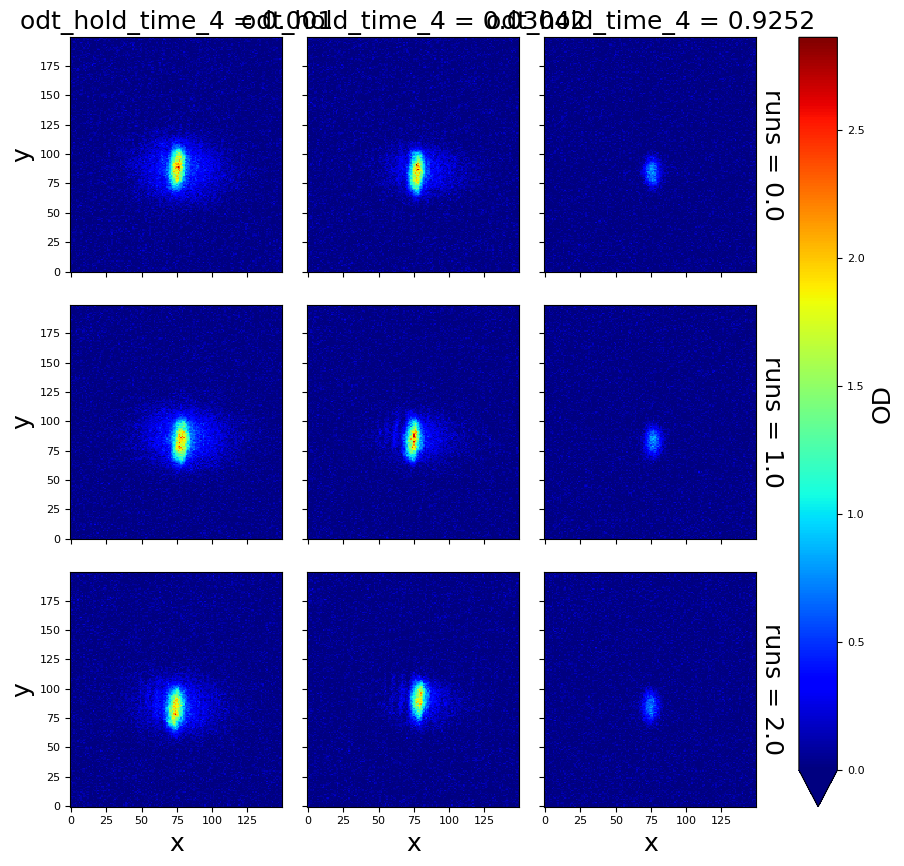

In [22]:
imageAnalyser.center = (960, 890)
imageAnalyser.span = (150, 200)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()
cropOD = dataSet_cropOD.to_numpy()
dataSet_cropOD.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])
plt.show()

In [14]:
# from opencv import moments
shape = np.shape(cropOD)
sigma = 0.4
blurred = gaussian_filter(cropOD, sigma=sigma)

thresh = np.zeros(shape)
for i in range(0,shape[0]):
    for j in range(0, shape[1]):
        thresh[i,j] = np.where(blurred[i,j] < np.max(blurred[i,j])*0.5,0,1)

center = calc_cen_bulk(thresh)

BEC_width_guess = guess_BEC_width(thresh, center)

X_guess_og = np.zeros((shape[0], shape[1], shape[3]))
# Y_guess_og = np.zeros((shape[0], shape[1], shape[2]))

for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        X_guess_og[i,j] = np.sum(cropOD[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2) , :], 0) / len(cropOD[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2),0])

        # Y_guess_og[i,j] = np.sum(cropOD[i,j, :, round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)], 1) / len(cropOD[i,j,0,round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)])

#[nr images x, nr images y, X / Y, center / sigma]
x = np.linspace(0,149,150)
y = np.linspace(0,199, 200)

popt = np.zeros((shape[0], shape[1], 6))

p0 = np.ones((shape[0], shape[1], 6))

max = np.zeros((shape[0], shape[1]))

for i in range(0, shape[0]):
    max[i] = np.ndarray.max(X_guess_og[i],axis=1)


p0[:, :, 0] = center[:, :, 0]  # center BEC
p0[:, :, 1] = center[:, :, 0]   # center th
p0[:, :, 2] = 0.7 * max          # amp BEC
p0[:, :, 3] = 0.3 * max         # amp th
p0[:, :, 4] = BEC_width_guess[:, :, 0]   # sigma BEC
p0[:, :, 5] = BEC_width_guess[:, :, 0] * 3          # sigma th

start = time.time()
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        popt[i,j], pcov = curve_fit(density_1d, x, X_guess_og[i,j] , p0[i, j], nan_policy='omit')
stop = time.time()

print(f'fitting time: {(stop-start)*1e3} ms')

fitting time: 118.55363845825195 ms


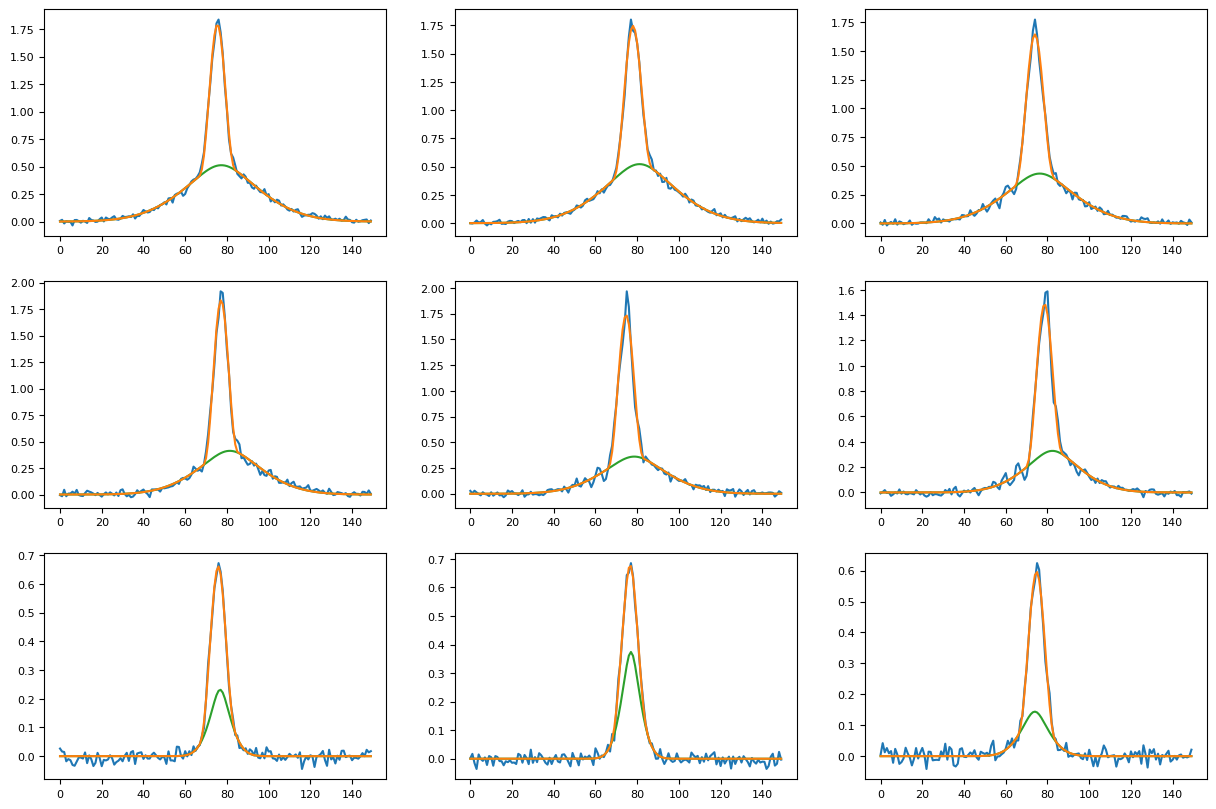

In [17]:
fsize=(15,10)
vmax = 1.5
fig, ax = plt.subplots(shape[0],shape[1],figsize=fsize)
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        lab = f"A$_{{BEC}}$ = {popt[i,j,0]:.1f} \n A$_{{th}}$ = {popt[i,j,1]:.1f} "
        ax[i,j].plot(x, X_guess_og[i,j])
        ax[i,j].plot(x, density_1d(x, *popt[i,j]), label = lab, zorder=3)
        ax[i,j].plot(x, thermal(x, popt[i,j,1], popt[i,j, 3], popt[i,j, 5]))


        #ax[i,j].legend(fontsize=10)
        ax[i,j].set_facecolor('#FFFFFF')
plt.show()


In [16]:
print(p0[0,0])
print(popt[0,0])

[75.69178082 75.69178082  1.28576093  0.5510404   8.         24.        ]
[75.41570333 77.33388115  2.56706786  0.32435386  9.02534473 21.78913789]


In [18]:
fitModel = DensityProfileBEC2dModel()
#fitModel.set_param_hint('deltax', value=5)

params = fitModel.make_params()
params.add_many(
    ('BEC_amplitude', np.max(data)/2, True, 0, np.max(data)),
    ('thermal_amplitude',np.max(data)/2, True, 0, np.max(data)),
    ('BEC_centerx',1),
    ('BEC_centery',1),
    ('thermal_centerx',1),
    ('thermal_centery',1),
    ('BEC_sigmay',1),
    ('thermal_sigmax',1),
    ('deltax',1),
    ('thermalAspectRatio',1)
)
params

type: name 'data' is not defined

In [12]:
params

Parameters([('BEC_amplitude', <Parameter 'BEC_amplitude', value=1.0, bounds=[0:inf]>), ('thermal_amplitude', <Parameter 'thermal_amplitude', value=1.0, bounds=[0:inf]>), ('BEC_centerx', <Parameter 'BEC_centerx', value=0.0, bounds=[-inf:inf]>), ('BEC_centery', <Parameter 'BEC_centery', value=0.0, bounds=[-inf:inf]>), ('thermal_centerx', <Parameter 'thermal_centerx', value=0.0, bounds=[-inf:inf]>), ('thermal_centery', <Parameter 'thermal_centery', value=0.0, bounds=[-inf:inf]>), ('BEC_sigmax', <Parameter 'BEC_sigmax', value=inf, bounds=[-inf:inf], expr='3 * thermal_sigmax - deltax'>), ('BEC_sigmay', <Parameter 'BEC_sigmay', value=1.0, bounds=[0:inf]>), ('thermal_sigmax', <Parameter 'thermal_sigmax', value=1.0, bounds=[0:inf]>), ('thermal_sigmay', <Parameter 'thermal_sigmay', value=-inf, bounds=[-inf:inf], expr='thermalAspectRatio * thermal_sigmax'>), ('deltax', <Parameter 'deltax', value=-inf, bounds=[0:inf]>), ('thermalAspectRatio', <Parameter 'thermalAspectRatio', value=-inf, bounds=[0.8:1.2]>), ('condensate_fraction', <Parameter 'condensate_fraction', value=0.5, bounds=[-inf:inf], expr='BEC_amplitude / (BEC_amplitude + thermal_amplitude)'>)])

## Fitting class

In [27]:
from lmfit import Model

In [28]:

def polylog(power, numerator):

    order = 2

    dataShape = numerator.shape
    numerator = np.tile(numerator, (order, 1))
    numerator = np.power(numerator.T, np.arange(1, order+1)).T

    denominator = np.arange(1, order+1)
    denominator = np.tile(denominator, (dataShape[0], 1))
    denominator = denominator.T

    data = numerator/ np.power(denominator, power)

    return np.sum(data, axis=0)

def ThomasFermi_2d(x, y=0.0, centerx=0.0, centery=0.0, amplitude=1.0, sigmax=1.0, sigmay=1.0):
    res = (1- ((x-centerx)/(sigmax))**2 - ((y-centery)/(sigmay))**2)**(3 / 2)
    return amplitude * np.where(res > 0, res, 0)
    # return amplitude * 5 / 2 / np.pi / max(tiny, sigmax * sigmay) * np.where(res > 0, res, 0)

def polylog2_2d(x, y=0.0, centerx=0.0, centery=0.0, amplitude=1.0, sigmax=1.0, sigmay=1.0):
    ## Approximation of the polylog function with 2D gaussian as argument. -> discribes the thermal part of the cloud
    return amplitude  * polylog(2, np.exp( -((x-centerx)**2/(2 * (sigmax)**2))-((y-centery)**2/( 2 * (sigmay)**2)) ))
    # return amplitude / 2 / np.pi / 1.20206 / max(tiny, sigmax * sigmay) * polylog(2, np.exp( -((x-centerx)**2/(2 * (sigmax)**2))-((y-centery)**2/( 2 * (sigmay)**2)) ))


def density_profile_BEC_2d(x, y=0.0, BEC_amplitude=1.0, thermal_amplitude=1.0, BEC_centerx=0.0, BEC_centery=0.0, thermal_centerx=0.0, thermal_centery=0.0,
                        BEC_sigmax=1.0, BEC_sigmay=1.0, thermal_sigmax=1.0, thermal_sigmay=1.0):

    return ThomasFermi_2d(x=x, y=y, centerx=BEC_centerx, centery=BEC_centery,
                          amplitude=BEC_amplitude, sigmax=BEC_sigmax, sigmay=BEC_sigmay
            ) + polylog2_2d(x=x, y=y, centerx=thermal_centerx, centery=thermal_centery,
                            amplitude=thermal_amplitude, sigmax=thermal_sigmax, sigmay=thermal_sigmay)


class DensityProfileBEC2dModel(Model):

    fwhm_factor = 2*np.sqrt(2*np.log(2))
    height_factor = 1./2*np.pi

    def __init__(self, independent_vars=['x', 'y'], prefix='', nan_policy='raise',
                 **kwargs):
        kwargs.update({'prefix': prefix, 'nan_policy': nan_policy,
                       'independent_vars': independent_vars})
        super().__init__(density_profile_BEC_2d, **kwargs)
        self._set_paramhints_prefix()

    def _set_paramhints_prefix(self):
        # self.set_param_hint('BEC_sigmax', min=0)
        self.set_param_hint('deltax', min=0)
        self.set_param_hint('BEC_sigmax', expr=f'3 * {self.prefix}thermal_sigmax - {self.prefix}deltax')

        self.set_param_hint('BEC_sigmay', min=0)
        self.set_param_hint('thermal_sigmax', min=0)
        # self.set_param_hint('thermal_sigmay', min=0)
        self.set_param_hint('BEC_amplitude', min=0)
        self.set_param_hint('thermal_amplitude', min=0)

        self.set_param_hint('thermalAspectRatio', min=0.8, max=1.2)
        self.set_param_hint('thermal_sigmay', expr=f'{self.prefix}thermalAspectRatio * {self.prefix}thermal_sigmax')

        # self.set_param_hint('betax', value=0)
        # self.set_param_hint('BEC_centerx', expr=f'{self.prefix}thermal_sigmax - {self.prefix}betax')

        self.set_param_hint('condensate_fraction', expr=f'{self.prefix}BEC_amplitude / ({self.prefix}BEC_amplitude + {self.prefix}thermal_amplitude)')

    def guess(self, data, x, y, negative=False, pureBECThreshold=0.5, noBECThThreshold=0.0, **kwargs):
        """Estimate initial model parameter values from data."""
        fitModel = TwoGaussian2dModel()
        pars = fitModel.guess(data, x=x, y=y, negative=negative)
        pars['A_amplitude'].set(min=0)
        pars['B_amplitude'].set(min=0)
        pars['A_centerx'].set(min=pars['A_centerx'].value - 3 * pars['A_sigmax'],
                              max=pars['A_centerx'].value + 3 * pars['A_sigmax'],)
        pars['A_centery'].set(min=pars['A_centery'].value - 3 * pars['A_sigmay'],
                              max=pars['A_centery'].value + 3 * pars['A_sigmay'],)
        pars['B_centerx'].set(min=pars['B_centerx'].value - 3 * pars['B_sigmax'],
                              max=pars['B_centerx'].value + 3 * pars['B_sigmax'],)
        pars['B_centery'].set(min=pars['B_centery'].value - 3 * pars['B_sigmay'],
                              max=pars['B_centery'].value + 3 * pars['B_sigmay'],)

        fitResult = fitModel.fit(data, x=x, y=y, params=pars, **kwargs)
        pars_guess = fitResult.params

        BEC_amplitude = pars_guess['A_amplitude'].value
        thermal_amplitude = pars_guess['B_amplitude'].value

        pars = self.make_params(BEC_amplitude=BEC_amplitude,
                                thermal_amplitude=thermal_amplitude,
                                BEC_centerx=pars_guess['A_centerx'].value, BEC_centery=pars_guess['A_centery'].value,
                                # BEC_sigmax=(pars_guess['A_sigmax'].value / 2.355),
                                deltax = 3 * (pars_guess['B_sigmax'].value * s2) - (pars_guess['A_sigmax'].value / 2.355),
                                BEC_sigmay=(pars_guess['A_sigmay'].value / 2.355),
                                thermal_centerx=pars_guess['B_centerx'].value, thermal_centery=pars_guess['B_centery'].value,
                                thermal_sigmax=(pars_guess['B_sigmax'].value * s2),
                                thermalAspectRatio=(pars_guess['B_sigmax'].value * s2) / (pars_guess['B_sigmay'].value * s2)
                                # thermal_sigmay=(pars_guess['B_sigmay'].value * s2)
                                )

        nBEC = pars[f'{self.prefix}BEC_amplitude'] / 2 / np.pi / 5.546 / pars[f'{self.prefix}BEC_sigmay'] / pars[f'{self.prefix}BEC_sigmax']
        if (pars[f'{self.prefix}condensate_fraction']>0.95) and (np.max(data) > 1.05 * nBEC):
            temp = ((np.max(data) - nBEC) * s2pi * pars[f'{self.prefix}thermal_sigmay'] / pars[f'{self.prefix}thermal_sigmax'])
            if temp > pars[f'{self.prefix}BEC_amplitude']:
                pars[f'{self.prefix}thermal_amplitude'].set(value=pars[f'{self.prefix}BEC_amplitude'] / 2)
            else:
                pars[f'{self.prefix}thermal_amplitude'].set(value=temp * 10)

        if BEC_amplitude / (thermal_amplitude + BEC_amplitude) > pureBECThreshold:
            pars[f'{self.prefix}thermal_amplitude'].set(value=0)
            pars[f'{self.prefix}BEC_amplitude'].set(value=(thermal_amplitude + BEC_amplitude))

        if BEC_amplitude / (thermal_amplitude + BEC_amplitude) < noBECThThreshold:
            pars[f'{self.prefix}BEC_amplitude'].set(value=0)
            pars[f'{self.prefix}thermal_amplitude'].set(value=(thermal_amplitude + BEC_amplitude))

        pars[f'{self.prefix}BEC_centerx'].set(
            min=pars[f'{self.prefix}BEC_centerx'].value - 10 * pars[f'{self.prefix}BEC_sigmax'].value,
            max=pars[f'{self.prefix}BEC_centerx'].value + 10 * pars[f'{self.prefix}BEC_sigmax'].value,
        )

        pars[f'{self.prefix}thermal_centerx'].set(
            min=pars[f'{self.prefix}thermal_centerx'].value - 3 * pars[f'{self.prefix}thermal_sigmax'].value,
            max=pars[f'{self.prefix}thermal_centerx'].value + 3 * pars[f'{self.prefix}thermal_sigmax'].value,
        )

        pars[f'{self.prefix}BEC_centery'].set(
            min=pars[f'{self.prefix}BEC_centery'].value - 10 * pars[f'{self.prefix}BEC_sigmay'].value,
            max=pars[f'{self.prefix}BEC_centery'].value + 10 * pars[f'{self.prefix}BEC_sigmay'].value,
        )

        pars[f'{self.prefix}thermal_centery'].set(
            min=pars[f'{self.prefix}thermal_centery'].value - 3 * pars[f'{self.prefix}thermal_sigmay'].value,
            max=pars[f'{self.prefix}thermal_centery'].value + 3 * pars[f'{self.prefix}thermal_sigmay'].value,
        )

        pars[f'{self.prefix}BEC_sigmay'].set(
            max=5 * pars[f'{self.prefix}BEC_sigmay'].value,
        )

        pars[f'{self.prefix}thermal_sigmax'].set(
            max=5 * pars[f'{self.prefix}thermal_sigmax'].value,
        )

        return update_param_vals(pars, self.prefix, **kwargs)